# Image classification with Convolutional Neural Network

## Import dependencies

At the beginning of each project, we import the libraries and required dependencies, as well as configure preferred settings in the notebook.

In [4]:
import keras
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import os
import seaborn as sns
import sys
from datetime import datetime

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils.plotting import plot_confusion_matrix
from model.trainer import Cifar10Trainer
from data.processing import standardize_data
from model.evaluate import evaluate_model
from utils.plotting import plot_confusion_matrix, plot_multi_auc
np.set_printoptions(threshold=sys.maxsize)
%matplotlib inline

/Users/khu834/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Load Dataset

The cifar10 dataset contains a total of 50,000 images for training, 10,000 images for testing.

Let's load the dataset and take a look at the contents to understand how it is structured.

The dataset is already avaiable as part of the Keras dataset library. We can use the method "cifar10.load_data" to load the data into an array in memory.

We will then inspect the array objects to see the contents.

In [22]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
label_list = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
label_decoder = {i: label for i, label in enumerate(label_list)}
print(f"the training dataset image dimensions are: {x_train.shape}")
print(f"the training dataset label dimensions are: {y_train.shape}")
print(f"the test dataset image dimensions are: {x_test.shape}")
print(f"the test dataset label dimensions are: {y_test.shape}")

the training dataset image dimensions are: (50000, 32, 32, 3)
the training dataset label dimensions are: (50000, 1)
the test dataset image dimensions are: (10000, 32, 32, 3)
the test dataset label dimensions are: (10000, 1)


### Question

What do the 4 numbers in the training dataset image dimensions mean?

What do the 2 numbers in the training data label dimensions mean?

### Answer

<br> <br>

## Explore the image dataset
`x_train` and `x_test` represent the training and test images in raw numerical numbers.

We see that the `x_train` object has a dimension of (50000, 32, 32, 3)

<br>
Here's how to interpret these dimensional numbers:

The first dimension is 50,000 units in length, this dimension indexes individual image examples

The second dimension is 32 units in length, this dimension is the vertical axis of the image

The third dimension is 32 units in length, this dimension is the horizontal axis of the image

The fourth dimension is 3 units in length, this dimension is the color channel axis of the image

<br>
`y_train` and `y_test` are the training and test ground truth labels for each of the image examples.

Let's take a look at the training image data.
We can select the first example, of the first channel (red color) 



In [21]:
print(x_train[0, ::2, ::2, 0])

[[ 59  50  98 139 149 131 142 137 137 124 139 136 152 168 158 152]
 [ 25  49 110 130 113 112 105 124 127 115 130 139 126 130 130 120]
 [ 50 102 124 120 107 129 108 121  98 117 134 131 135 121 103  75]
 [ 97 123 136 122 127 124 107  68 101  65  63 136 139 129  95  89]
 [137 132 119 128 121 131  54  44 203 162  77  74 107 135 127 125]
 [154 156 133 139 141  80  90 137 148 138 140 142 108 131 138 130]
 [142 140 147  84 109 138 178 211 205 213 199 161 124 130 134 136]
 [145 147 136  89  96 192 145 223 244 241 225 219 215 128 131 128]
 [149 144 132  84 163 206 196 220 245 234 195 208 227 145 140 121]
 [152 114 126  93 238 170 241 187 166 149 184 212 236 136 130 137]
 [143 129 130 219 210 166 191 128 149 147 141 202 198 100 119 108]
 [141 139 138 128 175 189 201 151 146 153 144 145 129 124 108 148]
 [149 136 150 157 175 166 224 192 146 141 153  77  93 133 113 187]
 [202 151 122 142 153 135 153 143 128 152 139 161 154 130 171 186]
 [220 186 156 142 150 126 148 131 127 150 149 126 145 127 186 

### Question
The notation of ::2 means selecting elements in steps of 2 (every other element). If we take every other element in the horizontal and vertical axis, how many numbers in the rows and columns do you expect?

### Answer

<br> <br>

There are a total of 10 object classes, they are each represented by a digit from 0 to 9.

Respectively, they are:

In [10]:
_ = [print(f"{label}, {value}") for label, value in label_decoder.items()]

0, airplane
1, automobile
2, bird
3, cat
4, deer
5, dog
6, frog
7, horse
8, ship
9, truck


Let's take a look at how many image examples are there per class

In [20]:
label_collections = {}
for i in range(len(label_decoder)):
    indices, _ = np.where(y_train == i)
    label_collections[i] = indices
    print(f"number of {label_decoder[i]} examples: {indices.size}")

number of airplane examples: 5000
number of automobile examples: 5000
number of bird examples: 5000
number of cat examples: 5000
number of deer examples: 5000
number of dog examples: 5000
number of frog examples: 5000
number of horse examples: 5000
number of ship examples: 5000
number of truck examples: 5000


## Precision / Recall

Two common metrics to measure the performance of classification models are 
1. Precison
2. Recall

Precision is defined as:

`number of correct positive predictions / number of predicted positive examples`

Recall is defined as:

`number of correct positive predictions / number of actual positive examples`


Below, we created a mocked up model which predicted the classification of 16 different images. Each image is shown with the actual label, as well as the predicted label.


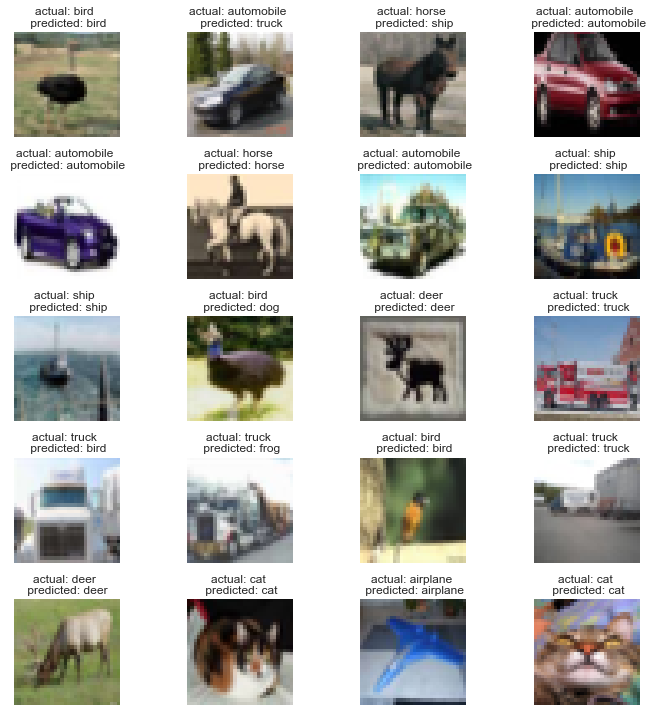

In [33]:
np.random.seed(423)
fig = plt.figure(figsize=(10, 10))
columns = 4
rows = 5
proba = 0.8
true_labels = []
preds = []
for i in range(1, columns*rows +1):
    img_id = np.random.choice(x_train.shape[0])
    img = x_train[img_id]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.xticks([], [])
    plt.yticks([], [])
    true_labels.append(y_train[img_id].item())
    if np.random.rand(1) > proba:
        preds.append(np.random.choice([x for x in range(10) if x != true_labels[i-1]]))
    else:
        preds.append(true_labels[i-1])
    plt.title(f"actual: {label_decoder[true_labels[i-1]]} \n predicted: {label_decoder[preds[i-1]]}")
fig.tight_layout()
plt.show()

### Question

A model produced the predictions above (given the actual label as shown)

What is the precision of the model?

What is the recall of the model?

### Answer

<br> <br>

## Confusion Matrix

A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known. Each row of the matrix represents the instances in a actual class while each column represents the instances in an predicted class.

Based on the same mock up model predictions for the 16 images, we can visualize the performance of the model using a confusion matrix. Each row of the confusion matrix table represents the actual class of each of the 16 image examples, while each column of the table represents the predicted class for the same images.

For instance, the top row is labeled `airplane`, looking across this row, we see that the number 1 appears in first column (which is Predicte label of `airplane`). This means that of the one image that is actually `airplane`, the model also predicted it to be `airplane`.

Let's take a look at the row labeled `bird`. Looking across this row, the number 2 appearing in a column also labeled `bird`. Meaning that 2 images are predicted correctly as `bird`. We also see that a number 1 appears in the predicted column labeled `dog`. This means the single image which is actually `bird` is predicted incorrectly as `dog`.

precision score of the model is 0.75
Confusion matrix, without normalization


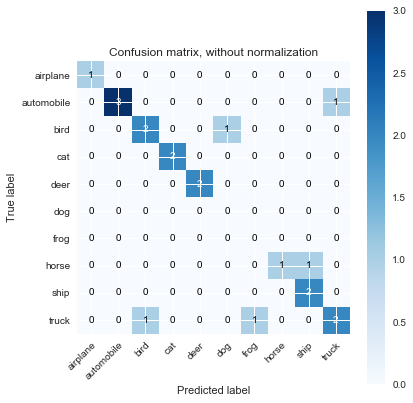

(<matplotlib.axes._subplots.AxesSubplot at 0x13f03f048>,
 array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 3, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 2, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 2, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 2, 0],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 2]]))

In [34]:
precision = precision_score(true_labels, preds, average="micro")
print(f"precision score of the model is {precision}")
plot_confusion_matrix(true_labels, preds, classes=label_list,
                      title='Confusion matrix, without normalization')

### Question

What is the model prediction accuracy for the class `horse`? Accuracy is defined as 

`the number of correct predictions / total number of images in that class`

Which classes of images did the model perform the worst on? i.e., lowest percentage of correct predictions.

Which classes of images did the model predicted perfectly on? i.e., all image labels correctly predicted

### Answer

<br> <br>

## RGB Image

Each image in the CIFAR10 dataset is composed of 3 color channels, Red, Green and Blue.

Below, we plot the colored image next to each of the channels in grayscale.


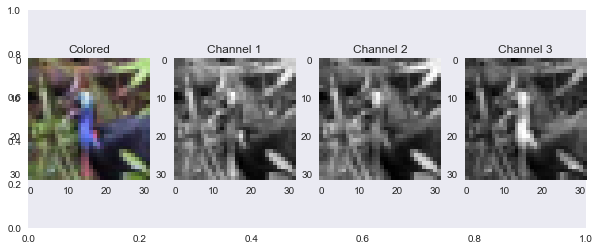

In [39]:
image_id_to_view = 24
image = x_train[image_id_to_view]
fig = plt.figure(figsize=(10, 4))
plt.grid(b=None)
fig.add_subplot(1, 4, 1)
plt.imshow(image)
plt.grid(b=None)
plt.title("Colored")
titles = ["Channel 1", "Channel 2", "Channel 3"]
for i in range(3):
    fig.add_subplot(1, 4, i + 2)
    plt.imshow(image[:,:,i], cmap='gray')
    plt.title(titles[i])
    plt.grid(b=None)

You can modify the `image_id_to_view` below and rerun the cell to see different images.

## Label one-hot-encoding

In [52]:
print(y_train[:10, 0])
print([label_decoder[x] for x in y_train[:10, 0]])

[6 9 9 4 1 1 2 7 8 3]
['frog', 'truck', 'truck', 'deer', 'automobile', 'automobile', 'bird', 'horse', 'ship', 'cat']


In [8]:
y_train_one_hot = keras.utils.to_categorical(y_train, num_classes=np.unique(y_train).size)
print(y_train_one_hot[:10,:])

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


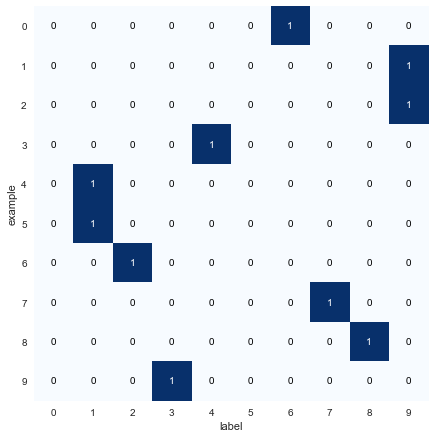

In [53]:
one_hot_plot = y_train_one_hot[:10,:].astype(int)
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(one_hot_plot, interpolation='nearest', cmap="Blues")
ax.grid(False)
fmt = 'd'
thresh = np.max(one_hot_plot) / 2
for i in range(one_hot_plot.shape[0]):
    for j in range(one_hot_plot.shape[1]):
        ax.text(j, i, format(one_hot_plot[i, j], fmt),
                ha="center", va="center",
                color="white" if one_hot_plot[i, j] > thresh else "black")
ax.set_xticks([x for x in range(len(label_list))])
ax.set_yticks([i for i in range(one_hot_plot.shape[0])])
fig.tight_layout()
plt.xlabel("label")
plt.ylabel("example")
plt.show()

## Data Preprocessing

Original pixel value distribution

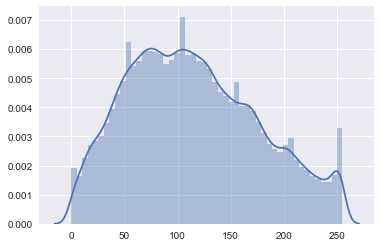

In [10]:
test_images = x_train[:100].copy()
sns.distplot(test_images.ravel(), bins=50)
plt.show()

Mean subtraction

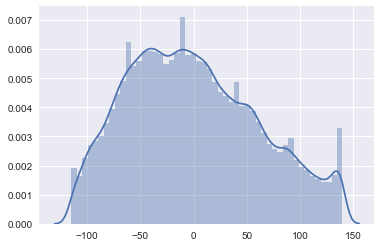

In [11]:
test_images = test_images.astype(float)
test_images -= np.mean(test_images)
sns.distplot(test_images.ravel(), bins=50)
plt.show()

Standardization

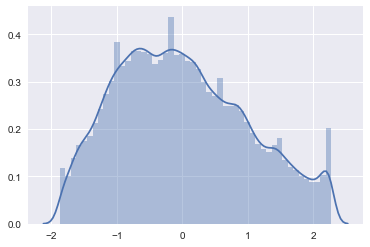

In [54]:
test_images /= np.std(test_images)
sns.distplot(test_images.ravel(), bins=50)
plt.show()

In [13]:
y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)
x_train = standardize_data(x_train)
x_test = standardize_data(x_test)

## Model Training

In [14]:
artifact_base = "/tmp/artifact/cifar10"

hyperparameters = {
  "learning_rate": 0.001,
  "batch_normalization": True,
  "weight_decay": 1e-4,
  "base_filters": 32,
  "batch_size": 64,
  "fc_size": 128,
  "dropout": 0.2,
  "lr_decay": 1e-6,
  "rotation_angle": 15,
  "width_shift_range": 0.1, 
  "height_shift_range": 0.1,
  "shear_range": 0.1,
  "zoom_range": 0.1,
  "horizontal_flip": True,
  "early_stopping_patience": 15,
  "reduce_lr_patience": 6,
  "reduce_lr_factor": 0.3,
  "activation": "relu",
  "classifier_activation": "softmax",
  "loss": "categorical_crossentropy"
}
job_name = "training_test_"
timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
artifact_directory = os.path.join(artifact_base, job_name+timestamp)

In [15]:
trainer = Cifar10Trainer(
    model_name="convnet6",
    hyperparameters=hyperparameters,
    artifact_directory=artifact_directory,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
__________

In [ ]:
trainer.train()

## Evaluate model

In [16]:
model_artifact = "../artifacts/weights.92-0.449348.hdf5"

Confusion matrix, without normalization


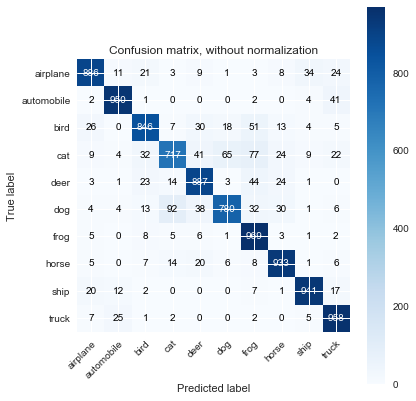

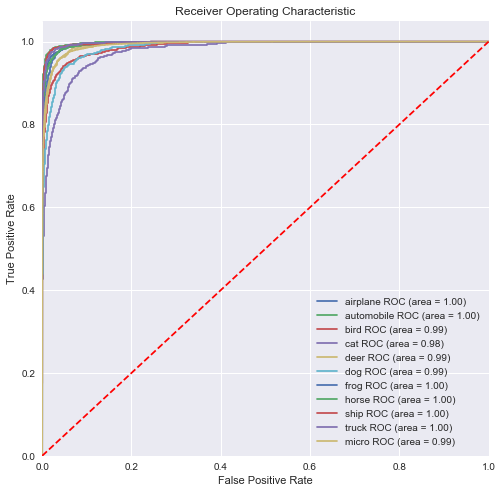

Accuracy: 0.8867


In [17]:
fpr, tpr, roc_auc, cm = evaluate_model(model_artifact, x_test, y_test, label_list)